<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Code

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

In [4]:
df = pd.read_csv('Data/train.csv') 
df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


#### Data Wrangling

In [5]:
df.dtypes

StudyInstanceUID              object
ETT - Abnormal                 int64
ETT - Borderline               int64
ETT - Normal                   int64
NGT - Abnormal                 int64
NGT - Borderline               int64
NGT - Incompletely Imaged      int64
NGT - Normal                   int64
CVC - Abnormal                 int64
CVC - Borderline               int64
CVC - Normal                   int64
Swan Ganz Catheter Present     int64
PatientID                     object
dtype: object

In [6]:
df.isna().sum() # Checking for missing values

StudyInstanceUID              0
ETT - Abnormal                0
ETT - Borderline              0
ETT - Normal                  0
NGT - Abnormal                0
NGT - Borderline              0
NGT - Incompletely Imaged     0
NGT - Normal                  0
CVC - Abnormal                0
CVC - Borderline              0
CVC - Normal                  0
Swan Ganz Catheter Present    0
PatientID                     0
dtype: int64

In [7]:
df.duplicated().sum() # Checking for duplicates

0

#### Exploratory Data Analysis

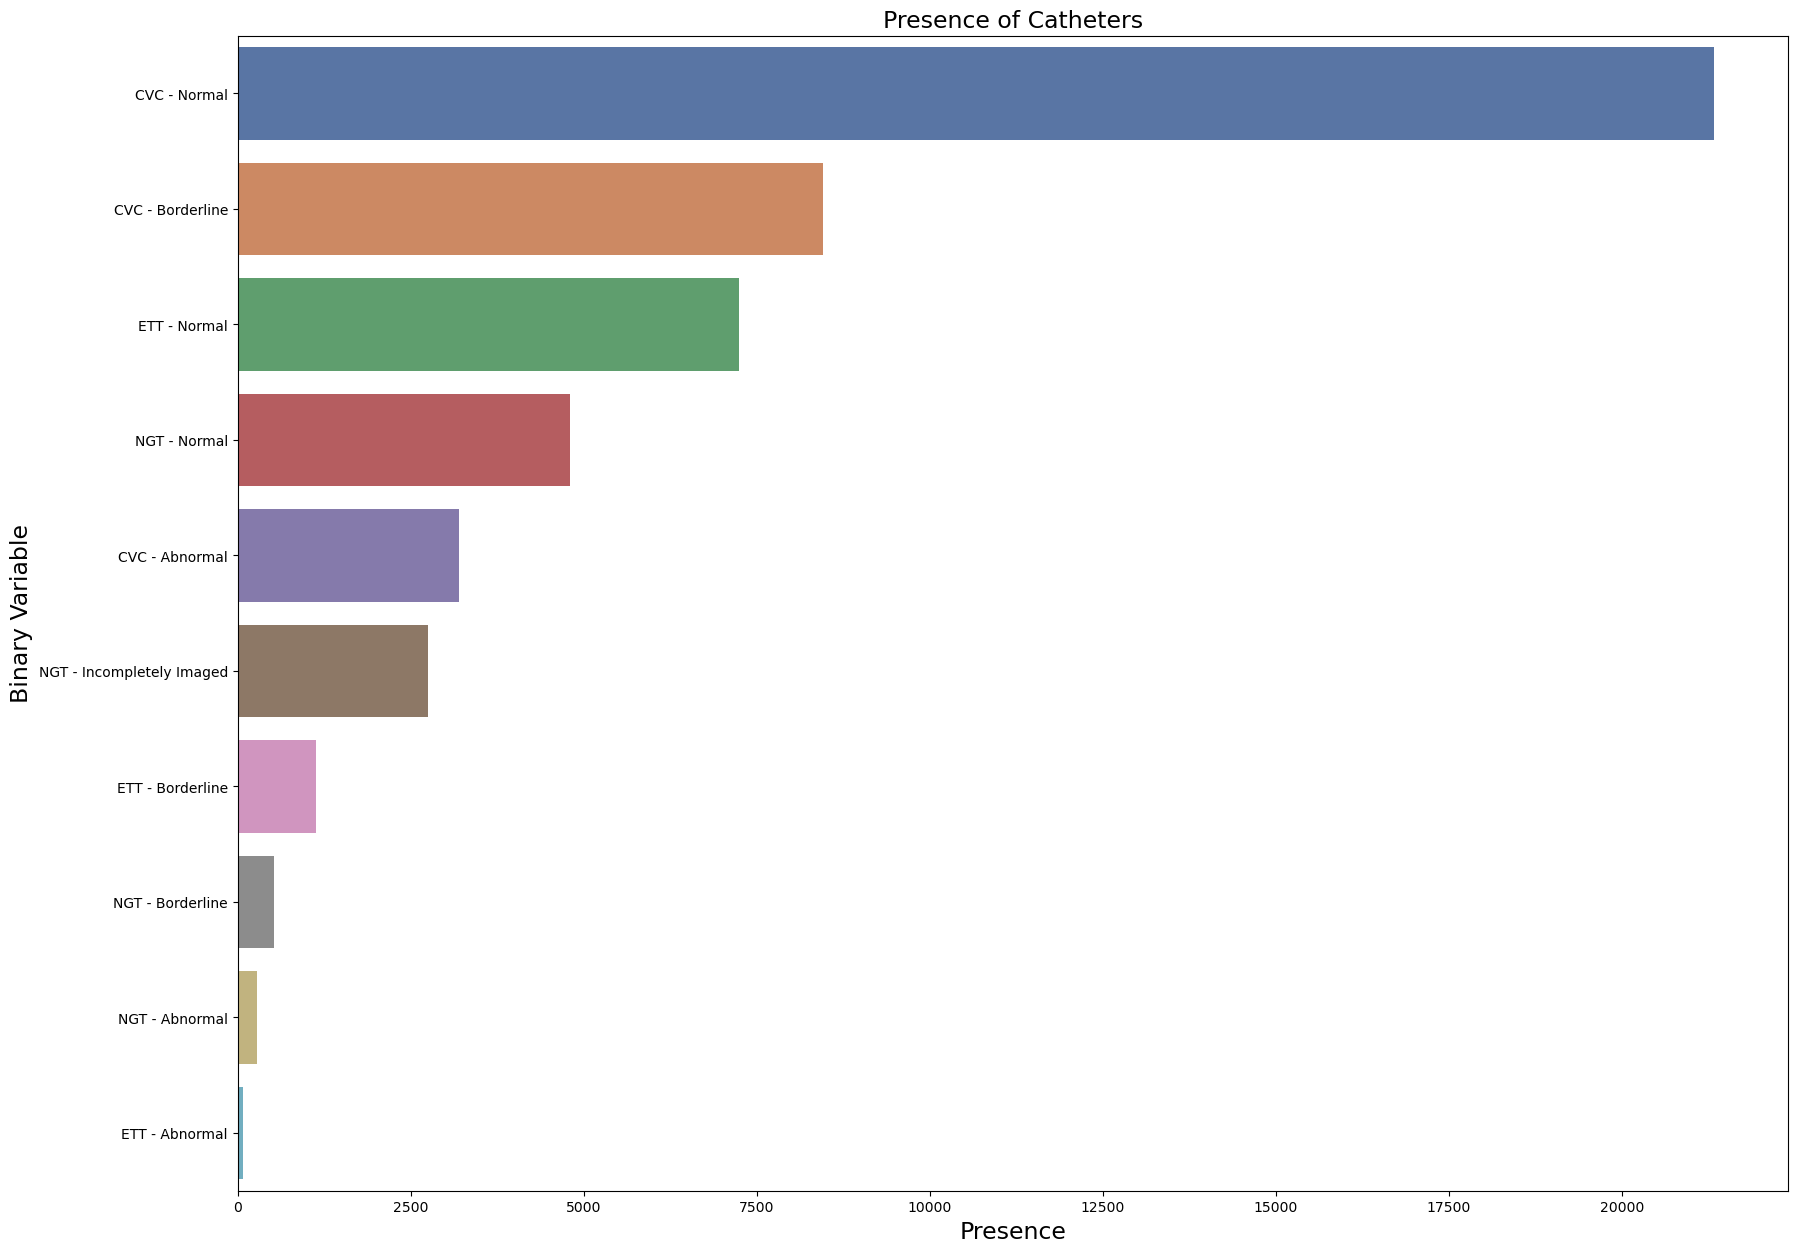

In [43]:
# create a list of binary variable names
binary_vars = ['ETT - Abnormal','ETT - Borderline','ETT - Normal','NGT - Abnormal','NGT - Borderline',
'NGT - Incompletely Imaged','NGT - Normal','CVC - Abnormal','CVC - Borderline','CVC - Normal']

presence_of_catheters = df[binary_vars].sum()

presence_of_catheters = presence_of_catheters.sort_values(ascending=False)

plt.figure(figsize=(20,15))
sns.barplot(x=presence_of_catheters.values, y=presence_of_catheters.index, palette='deep')

plt.title('Presence of Catheters',fontsize=17)
plt.xlabel('Presence',fontsize=17)
plt.ylabel('Binary Variable',fontsize=17)
plt.show()

Number of unique patients:  3255


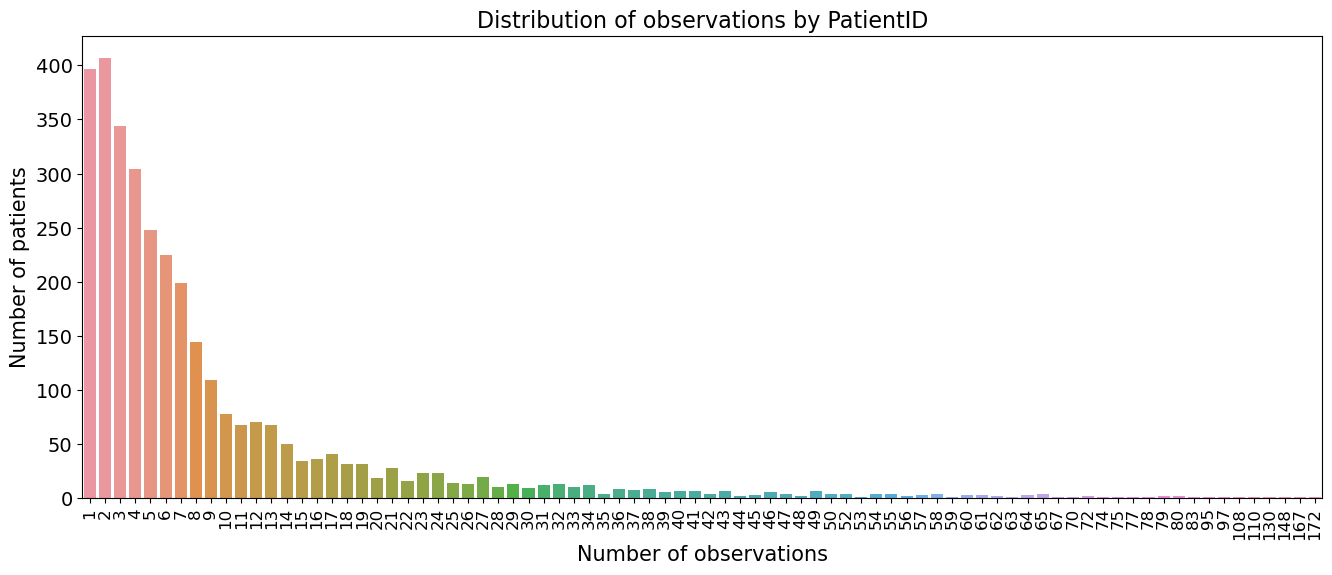

In [21]:
print("Number of unique patients: ", df["PatientID"].unique().shape[0])
plt.figure(figsize=(16, 6))
df_tmp = df["PatientID"].value_counts()
sns.countplot(x=df_tmp.values)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Number of observations", fontsize=15)
plt.ylabel("Number of patients", fontsize=15)
plt.title("Distribution of observations by PatientID", fontsize=16);

In [35]:
patient_data = df.groupby(['PatientID']).sum()
patient_data.describe()

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,0.024270,0.349616,2.224270,0.085714,0.162519,0.844240,1.473733,0.981567,2.599078,6.551152,0.254992
std,0.179704,1.356327,8.284068,0.679194,0.967992,3.554909,5.178721,2.493562,5.532432,9.891937,1.733501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,7.000000,0.000000
max,3.000000,19.000000,158.000000,31.000000,33.000000,97.000000,101.000000,58.000000,110.000000,119.000000,50.000000
